In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import seaborn as sns

from yahoofinancials import YahooFinancials

# set plotting style
sns.set(style="ticks", 
        palette="PiYG", 
        font_scale=1.1,
        rc = {"lines.linewidth": 2, 
              "xtick.color" : "#4f4e4e",
              "ytick.color" : "#4f4e4e",
              "axes.spines.top" : False,
              "axes.spines.right" : False,
              "axes.edgecolor": "#4f4e4e",
              "axes.labelcolor": "#4f4e4e",
              "axes.titlesize": 16,
              "axes.titlecolor": "#4f4e4e",
             })

%config InlineBackend.figure_format = 'retina'

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# uncomment below to view the available rc parameters
# plt.rcParams.keys()

In [2]:
class TradingSimulation:
    """Return a dataframe with historical prices, number of shares and portfolio value at a point in time.
    Parameters
    ----------
    df: dataframe of historical prices returned by package yahoofinancials.
    interval: number of day intervals to trade.
    amount: total amount of money to be invested during the back testing period.
    price: default to closing price of the stock.
    Returns
    -------
    Dataframe with price, number of shares and portfoli value.
    """
    def __init__(self, df, interval, amount, price="close"):
        self.df = df
        self.interval = interval
        self.amount = amount
        self.price = price
        
    def _random_stock_pick(self, df, interval, price):
        num_records = df.shape[0]
        # to create an array per interval for sampling, need to remove extra rows
        rows_to_keep = num_records - num_records % interval
        prices_array = df[:rows_to_keep][price].values.reshape(-1, interval)
        date_array = df[:rows_to_keep].index.values.reshape(-1, interval)
        idx = np.random.randint(0, prices_array.shape[1], prices_array.shape[0])
        
        return prices_array[np.arange(len(idx)), idx], date_array[np.arange(len(idx)), idx], 
    
    def compute_portfolio(self):
        prices_bought_at, date = self._random_stock_pick(self.df, self.interval, self.price)
        amount_invested_each_trade = self.amount / len(prices_bought_at)
        num_shares_each_trade = amount_invested_each_trade / prices_bought_at
        
        # to calculae the cumulative sum of shares purchased at a point in time
        total_shares_at_each_trade = np.cumsum(num_shares_each_trade)
        # create a dataframe with trading transaction date, number of shares and prices on that date
        trading_record = pd.DataFrame({"number_of_shares":total_shares_at_each_trade, 
                                      "prices":prices_bought_at}, 
                                      index=date)
        
        # concat the result to the original price records of the stock for calculation of portfolio value each day
        result = pd.concat([self.df[self.price],  trading_record["number_of_shares"]], axis=1)
        # use forward fill to fill any missing value with the previous number of shares
        result.fillna(method='ffill', inplace=True)
        # then fill any missing value with 0; this should only apply to the first few days before the 1st trade
        result.fillna(0, inplace=True)
        result["portfolio_value"] = result[self.price] * result["number_of_shares"]
        
        return result

In [3]:
def run_simulation(n_simulations, df, intervals, amounts, current_price):
    portfolio_a = []
    portfolio_b = []
    
    for i in range(n_simulations):
        strategy_a = TradingSimulation(df, intervals[0], amounts)
        total_value_a = strategy_a.compute_portfolio().iloc[-1]["portfolio_value"]
        portfolio_a.append(total_value_a)
        
        strategy_b = TradingSimulation(df, intervals[1], amounts)
        total_value_b = strategy_b.compute_portfolio().iloc[-1]["portfolio_value"]
        portfolio_b.append(total_value_b)
    
    return portfolio_a, portfolio_b

In [4]:
# parameters you can change to explore other stock tickers and investment horizon
START_DATE = "2016-02-08"
END_DATE = "2021-02-08"
SELECTED_TICKER = 'DIS'

In [5]:
# save results retruend by the API call
result = YahooFinancials(SELECTED_TICKER)
current_price = result.get_current_price()

In [6]:
# return hisorical prices under the selected ticker
historical_raw = result.get_historical_price_data(START_DATE, END_DATE, "daily")

In [7]:
# drop unix timestamp
historical_price = pd.DataFrame(historical_raw[SELECTED_TICKER]["prices"]).drop(columns="date")

# convert formatted_date to datetime in pandas
historical_price["formatted_date"] = pd.to_datetime(historical_price["formatted_date"])

# set date as index of the dataframe
historical_price.set_index("formatted_date", inplace=True)

# add difference between open and close as a new column
historical_price["diff"] = historical_price["open"] - historical_price["close"]

# drop null values, if any
historical_price = historical_price.dropna()

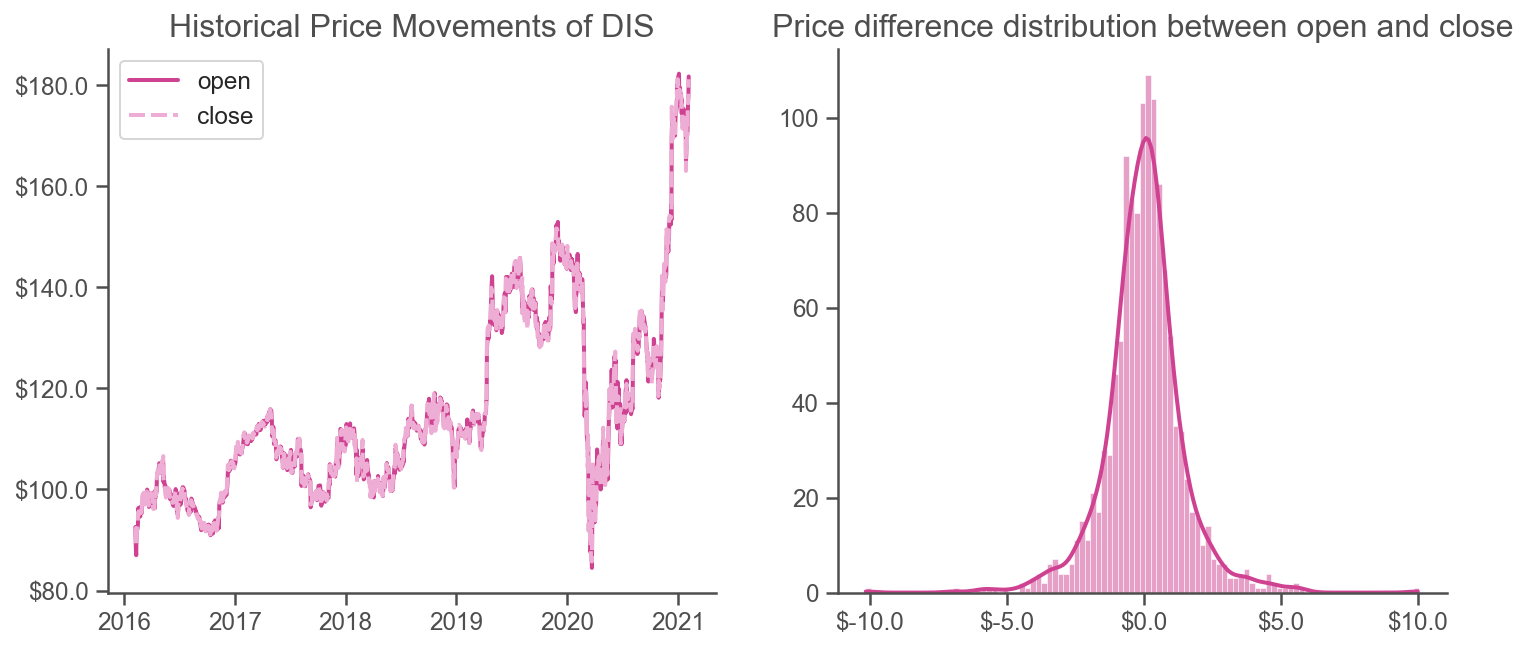

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

# plot historical open and close prices
sns.lineplot(data=historical_price[["open", "close"]], ax=ax1)
ax1.yaxis.set_major_formatter('${x:1.1f}')
ax1.set_title(f"Historical Price Movements of {SELECTED_TICKER}")
ax1.set(xlabel=None, ylabel=None)

# plot differences between open and close
sns.histplot(data=historical_price["diff"], binwidth=0.2, kde=True, ax=ax2)
ax2.xaxis.set_major_formatter('${x:1.1f}')
ax2.set_title(f"Price difference distribution between open and close")
ax2.set(xlabel=None, ylabel=None)

plt.show()

In [9]:
# hypothesis test on if the difference between historical open and close was > 0
scipy.stats.ttest_1samp(historical_price["diff"], 0, alternative='greater')

Ttest_1sampResult(statistic=0.3942285542086391, pvalue=0.3467395616299669)

In [10]:
# a, b = run_simulation(10000, 
#                       historical_price, 
#                       [5, 20], 
#                       50000, 
#                       current_price)

In [11]:
# scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater')

In [12]:
result = TradingSimulation(historical_price, 5, 50000)
result2 = TradingSimulation(historical_price, 365, 50000)

In [13]:
test = result.compute_portfolio()
test2 = result2.compute_portfolio()

In [14]:
test2[test2['number_of_shares'] > 0].head(20)

,close,number_of_shares,portfolio_value
2016-07-05,97.66,170.66,16666.67
2016-07-06,98.45,170.66,16801.49
2016-07-07,98.41,170.66,16794.66
2016-07-08,99.62,170.66,17001.16
2016-07-11,99.98,170.66,17062.60
2016-07-12,100.20,170.66,17100.14
2016-07-13,99.88,170.66,17045.53
2016-07-14,99.97,170.66,17060.89
2016-07-15,99.80,170.66,17031.88
2016-07-18,100.15,170.66,17091.61


In [15]:
combined = pd.concat([test["portfolio_value"],  test2["portfolio_value"]], axis=1)
names=["value1", "value2"]
combined.columns = names

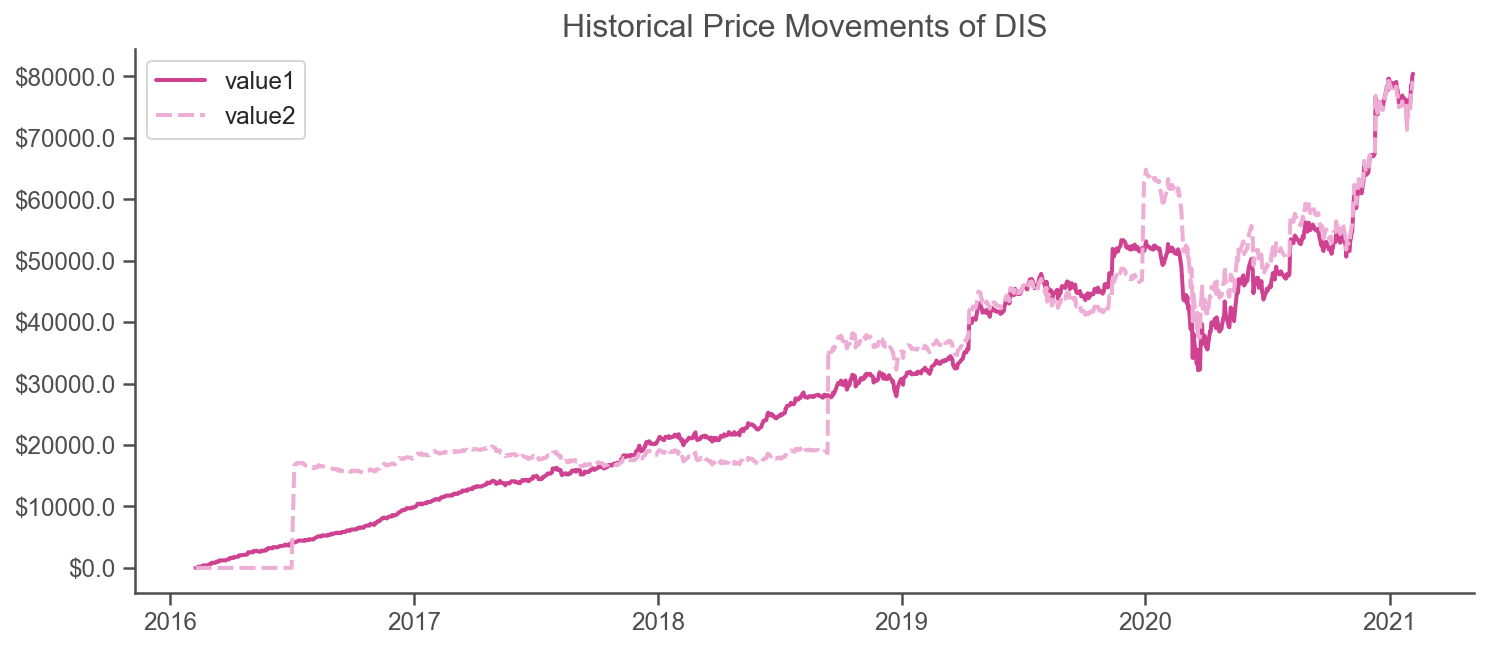

In [16]:
fig, ax = plt.subplots(figsize = (12, 5))

# plot historical open and close prices
sns.lineplot(data=combined[["value1", "value2"]])
ax.yaxis.set_major_formatter('${x:1.1f}')
ax.set_title(f"Historical Price Movements of {SELECTED_TICKER}")
ax.set(xlabel=None, ylabel=None)
plt.show()